In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import time
tfk = tf.keras
tfkl = tf.keras.layers

BATCH_SIZE = 64
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Warning: no GPU is running")

Computing weights for each class


In [2]:
labels = os.listdir("./train")
counts = []
weights = {}
for label in labels:
    counts.append(len(os.listdir(f"./train/{label}")))
total = sum(counts)

for index, c in enumerate(counts):
    weights[index] = (1 / c) * (total / 2.0)
weights

{0: 9.557432432432433,
 1: 3.328235294117647,
 2: 3.4332524271844655,
 3: 3.4669117647058822,
 4: 3.3360849056603774,
 5: 7.991525423728813,
 6: 3.297202797202797,
 7: 3.4839901477832513}

Method for creating training and validation test.

In [3]:
# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rescale=1/255.)
valid_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory="./train",
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory="./val",
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 705 images belonging to 8 classes.


In [4]:
from tensorflow.keras.layers import Dense, Activation, Conv2D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    """conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)"""

    flattening_layer = tfkl.Flatten(name='Flatten')(pool2)
    dropout = tfkl.Dropout(0.4, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=100, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='swish')(dropout)
    dropout1 = tfkl.Dropout(0.4, seed=seed)(classifier_layer)
    classifier_layer2 = tfkl.Dense(units=50, name='Classifier2', kernel_initializer=tfk.initializers.HeUniform(seed), activation='swish')(dropout1)
    dropout2 = tfkl.Dropout(0.4, seed=seed)(classifier_layer2)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)
    
    
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name="model")

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [5]:
epochs = 100

In [6]:
input_shape = (96, 96, 3)
m1 = build_model(input_shape)


model_name = f"cnn-weightedloss-epochs_{epochs}-batch_{BATCH_SIZE}-t-{int(time.time())}"
tensorboard = TensorBoard(log_dir=f"logs/{model_name}")

h1 = m1.fit(x=train_gen,
            epochs=epochs,
            validation_data=valid_gen,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=20), tensorboard],
            class_weight=weights
        )

Epoch 1/100
45/45 [==============================] - 13s 272ms/step - loss: 9.0559 - accuracy: 0.1527 - val_loss: 1.9821 - val_accuracy: 0.3149
Epoch 2/100
45/45 [==============================] - 10s 213ms/step - loss: 7.8784 - accuracy: 0.2192 - val_loss: 1.7865 - val_accuracy: 0.3376
Epoch 3/100
45/45 [==============================] - 10s 211ms/step - loss: 7.4452 - accuracy: 0.2899 - val_loss: 1.7025 - val_accuracy: 0.4085
Epoch 4/100
45/45 [==============================] - 10s 210ms/step - loss: 6.9834 - accuracy: 0.3309 - val_loss: 1.5608 - val_accuracy: 0.4411
Epoch 5/100
45/45 [==============================] - 10s 215ms/step - loss: 6.5008 - accuracy: 0.3934 - val_loss: 1.5001 - val_accuracy: 0.4695
Epoch 6/100
45/45 [==============================] - 10s 221ms/step - loss: 5.9863 - accuracy: 0.4224 - val_loss: 1.4516 - val_accuracy: 0.4596
Epoch 7/100
45/45 [==============================] - 10s 214ms/step - loss: 5.4893 - accuracy: 0.4882 - val_loss: 1.3589 - val_accuracy:

In [7]:
y_predicted = m1.predict(valid_gen)
y_predicted = tf.argmax(y_predicted, axis=1)

test_loss, test_acc = m1.evaluate(valid_gen)
print(test_acc)

12/12 [==============================] - 2s 133ms/step - loss: 1.6474 - accuracy: 0.5191
0.5191489458084106


In [8]:
y_test_labels = tf.keras.utils.to_categorical(
    valid_gen.labels, num_classes=None, dtype='float32'
)

In [9]:
y_test_labels = tf.argmax(y_test_labels, axis=1)

In [10]:
confusion_matrix = tf.math.confusion_matrix(
    y_test_labels, 
    y_predicted,
    num_classes=8
)
c = []
for item in confusion_matrix:
    c.append(np.around(item / np.sum(item), decimals=3))
df_heatmap = pd.DataFrame(c)

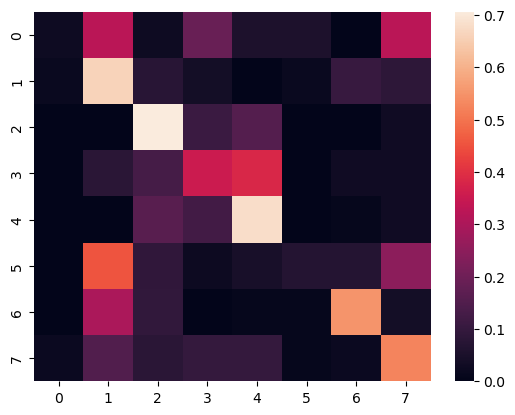

In [11]:
sns.heatmap(df_heatmap)
plt.show()